In [1]:
%load_ext autoreload
%autoreload 2
import os

In [2]:
data_path = "data/news.csv"
first_n_words = 200

In [3]:
def trim_string(x):

    x = x.split(maxsplit = first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

In [4]:
import pandas as pd
df = pd.read_csv(data_path)
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
df['label'] = (df['label'] == 'FAKE').astype('int')
df['titletext'] = df['title'] + ". " + df['text']
df = df.reindex(columns=['label', 'title', 'text', 'titletext'])
df.head()

,label,title,text,titletext
0,1,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear. Daniel Greenfiel...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy. U...
3,1,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matte...


In [6]:
# Drop rows with empty text
df.drop( df[df.text.str.len() < 5].index, inplace=True)

In [7]:
# Trim text and titletext to first_n_words
df['text'] = df['text'].apply(trim_string)
df['titletext'] = df['titletext'].apply(trim_string) 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(df, train_size = 0.8, random_state = 2023)
X_val, X_test = train_test_split(X_valid, train_size = 0.5, random_state = 2023)
print(len(X_train))
print(len(X_val))
print(len(X_test))

5039
630
630


In [9]:
X_train.to_csv("data/news_train.csv", index = False)
X_val.to_csv("data/news_val.csv", index = False)
X_test.to_csv("data/news_test.csv", index = False)

In [10]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(device)
print(tokenizer)

cuda:1
BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [11]:
from torchtext.data import Field

max_len = 128
pad_ind = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
unk_ind = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=max_len, pad_token=pad_ind, unk_token=unk_ind)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

In [12]:
from torchtext.data import TabularDataset, BucketIterator, Iterator

source_folder = "data"
train, valid, test = TabularDataset.splits(path=source_folder, train='news_train.csv', validation='news_val.csv',
                                           test='news_test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


In [13]:
from torch import nn

class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [14]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [1]:
add_numbers = lambda x, y: x + y
print(add_numbers(5, 3))  # Output: 8

8


In [2]:
def add_numbers_func(x, y): return x + y
print(add_numbers_func(5, 3))  # Output: 8
print(add_numbers(5, 3))  # Output: 8

8
8


In [16]:
# Training Function
from torch import optim
def train(model,
          save_prefix,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = "modellar",
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, title, text, titletext), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + f'{save_prefix}_model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + f'{save_prefix}_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + f'{save_prefix}_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [17]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, save_prefix = "bert_new", optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [157/1575], Train Loss: 0.4782, Valid Loss: 0.1612
Model saved to ==> modellar/bert_new_model.pt
Model saved to ==> modellar/bert_new_metrics.pt
Epoch [1/5], Step [314/1575], Train Loss: 0.1473, Valid Loss: 0.1468
Model saved to ==> modellar/bert_new_model.pt
Model saved to ==> modellar/bert_new_metrics.pt
Epoch [2/5], Step [471/1575], Train Loss: 0.1581, Valid Loss: 0.0596
Model saved to ==> modellar/bert_new_model.pt
Model saved to ==> modellar/bert_new_metrics.pt
Epoch [2/5], Step [628/1575], Train Loss: 0.0521, Valid Loss: 0.0862
Epoch [3/5], Step [785/1575], Train Loss: 0.0877, Valid Loss: 0.0803
Epoch [3/5], Step [942/1575], Train Loss: 0.0379, Valid Loss: 0.0663
Epoch [4/5], Step [1099/1575], Train Loss: 0.0697, Valid Loss: 0.0590
Model saved to ==> modellar/bert_new_model.pt
Model saved to ==> modellar/bert_new_metrics.pt
Epoch [4/5], Step [1256/1575], Train Loss: 0.0135, Valid Loss: 0.0608
Epoch [5/5], Step [1413/1575], Train Loss: 0.0309, Valid Loss: 0.0649


Model loaded from <== modellar/bert_metrics.pt


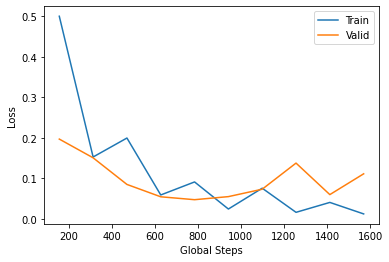

In [18]:
from matplotlib import pyplot as plt

train_loss_list, valid_loss_list, global_steps_list = load_metrics("modellar" + '/bert_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [19]:
# Evaluation Function
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, dim = 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== modellar/bert_new_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9710    0.9465    0.9586       318
           0     0.9469    0.9712    0.9589       312

    accuracy                         0.9587       630
   macro avg     0.9589    0.9588    0.9587       630
weighted avg     0.9590    0.9587    0.9587       630



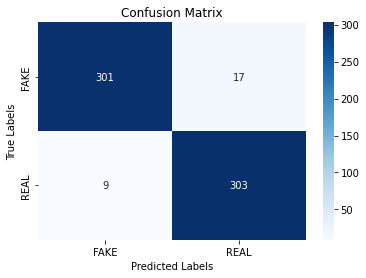

In [20]:
best_model = BERT().to(device)
load_checkpoint("modellar" + '/bert_new_model.pt', best_model)

evaluate(best_model, test_iter)

In [31]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    
    def __init__(self, root, data_nomi, tokenizer):
        
        self.data = pd.read_csv(f"{root}/news_{data_nomi}.csv")
        # print(self.data.head())
        
    def __len__(self): return len(self.data)
        
    def __getitem__(self, idx): 
        
        label = self.data.iloc[idx]["label"] 
        title = self.data.iloc[idx]["title"] 
        text = self.data.iloc[idx]["text"] 
        titletext = self.data.iloc[idx]["titletext"] 
        
        return label, tokenizer.encode(title), tokenizer.encode(text), titletext

ds = CustomDataset(root = "data", data_nomi = "train", tokenizer = tokenizer)
ds[202]

(1,
 [101,
  2413,
  1011,
  2887,
  25077,
  3886,
  1999,
  16416,
  24817,
  12677,
  2015,
  1996,
  4517,
  3068,
  102],
 [101,
  2131,
  5710,
  999,
  4748,
  16874,
  5562,
  2182,
  1012,
  2424,
  2041,
  2062,
  22223,
  12677,
  2015,
  1996,
  4517,
  3068,
  2011,
  10930,
  11319,
  11895,
  18900,
  6342,
  1023,
  1011,
  2459,
  1011,
  2385,
  1037,
  14163,
  15952,
  4773,
  1997,
  2248,
  4425,
  8859,
  2003,
  2108,
  6086,
  1999,
  1996,
  25077,
  1011,
  3886,
  3033,
  9446,
  14934,
  1996,
  2413,
  1998,
  2887,
  4517,
  6088,
  1012,
  3809,
  2019,
  9626,
  11983,
  2031,
  2042,
  3603,
  1999,
  3145,
  3886,
  6177,
  2005,
  1996,
  2647,
  2811,
  28405,
  2300,
  13308,
  1006,
  1041,
  1011,
  1052,
  13088,
  1007,
  2108,
  3833,
  2012,
  13109,
  23093,
  3077,
  1010,
  2605,
  1010,
  2006,
  1996,
  2394,
  3149,
  1012,
  1996,
  3522,
  7524,
  1997,
  24650,
  3886,
  2038,
  2419,
  2000,
  1037,
  21396,
  7770,
  9634,
  2011,
